# Doctor Who - Actor Timeline

## Topics & Techniques Covered

* Extracting text data from a Wikipedia table
* Pandas `.read_html()`
* Regular expressions (Python `re` module)
* Getting time series data out of text data
* Python's `datetime` module and the `dateutil` package
* Timeline visualization

In this example, we will be creating a barplot that shows which actors played The Doctor on Doctor Who at which times. There is a Wikipedia article that shows this in a table, but we'd like to visualize the data.

https://en.wikipedia.org/wiki/List_of_actors_who_have_played_the_Doctor

## Imports

In [43]:
import re
import datetime
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### `requests`

We will be using the `requests` module to perform a "get" HTTP request to the aforementioned Wikipedia page.

There are four types of HTTP requests: `get`, `put`, `post`, and `delete`. We aren't hosting the page in question, so we'll just be using a `get` request.

For a more extensive tutorial on the `requests` module and on web-scraping, please see the archived "Practical Python" workshop materials on the Library's "[Introduction to Python](https://libguides.libraries.claremont.edu/intro-to-python)" Research Guide.

Once we get the page's data, we will use pandas to convert the table in question to a DataFrame, and then use regular expressions to clean the data and make it usable.

In [44]:
#This next line may be commented out after running to avoid sending
#a request more than necessary; requests typically have a rate limit

url = 'https://en.wikipedia.org/wiki/List_of_actors_who_have_played_the_Doctor'

#It's important to honor Wikipedia's robots policy; we're including a User Agent string to identify ourselves.
headers = {
    'User-Agent': 'Persnickety Python Workshop; The Claremont Colleges Library (https://library.claremont.edu/); workshop author: david.merten-jones@claremont.edu',
    'Accept-Encoding': 'gzip'
}

r = requests.get(url, headers=headers)
page_data = r.content

### pandas read_html (The Easy Way)

In [3]:
wiki_data = pd.read_html(page_data)

Pandas's `.read_html()` method grabs *all* the tables it finds in html code. Luckily for us, the table we want is the first one on the page, so we can look at the table at index \[0] returned by `pd.read_html()`.

In [4]:
wiki_data[0]

,Actor (role),Tenure,First regular appearance,Last regular appearance
0,William Hartnell (First Doctor),"23 November 1963 – 29 October 1966 (2 years, 1...","An Unearthly Child ""An Unearthly Child""[2]",The Tenth Planet Episode 4[3]
1,William Hartnell (First Doctor),Other First Doctor appearances William Hartnel...,Other First Doctor appearances William Hartnel...,Other First Doctor appearances William Hartnel...
2,Patrick Troughton (Second Doctor),"29 October 1966 – 21 June 1969 (2 years, 7 mon...",The Power of the Daleks Episode One[6],The War Games Episode Ten[3]
3,Patrick Troughton (Second Doctor),Other Second Doctor appearances Television: Th...,Other Second Doctor appearances Television: Th...,Other Second Doctor appearances Television: Th...
4,Jon Pertwee (Third Doctor),"3 January 1970 – 8 June 1974 (4 years, 5 month...",Spearhead from Space Episode One,Planet of the Spiders Part Six[3]
5,Jon Pertwee (Third Doctor),"Other Third Doctor appearances Television: ""Th...","Other Third Doctor appearances Television: ""Th...","Other Third Doctor appearances Television: ""Th..."
6,Tom Baker (Fourth Doctor),"8 June 1974 – 21 March 1981 (6 years, 9 months...",Robot Part One[8],Logopolis Part Four[3]
7,Tom Baker (Fourth Doctor),"Tom Baker also appeared as the Curator in ""The...","Tom Baker also appeared as the Curator in ""The...","Tom Baker also appeared as the Curator in ""The..."
8,Peter Davison (Fifth Doctor),"21 March 1981 – 16 March 1984 (2 years, 11 mon...",Castrovalva Part One,The Caves of Androzani Part Four[3]
9,Peter Davison (Fifth Doctor),Other Fifth Doctor appearances Television: Blu...,Other Fifth Doctor appearances Television: Blu...,Other Fifth Doctor appearances Television: Blu...


We want to create a visualization of how long each actor portrayed The Doctor. The chronological data in this dataset is all in the "Tenure" column. However, both the start and end dates are in the same field among other text and punctuation.

Fortunately for our purposes, all the Doctors' dates are listed in a predictable pattern: a one-or-two-digit number, the full name of the month, then the four-digit year. We can use the Python regular expressions module `re` to extract their starting and ending years.

### Regular Expressions

What are regular expressions?

[Regular expressions](https://en.wikipedia.org/wiki/Regular_expression) (or regex for short) are sequences of characters that can be used to find segments of text that match specified characteristics. They are used in search engines and in-page/in-document searches.

Regex is not a programming language unto itself, but rather a syntax for pattern-recognition. This syntax is the same across implementations in different programming languages and software systems.

There are many free resources for learning regex patterns; you will not need to memorize them in order to use them, but you will need to understand how they are assembled.

Both regexr and regex101 offer live platforms to test out patterns on sample text; this can be a very effective means of developing new regex patterns. 

[regexr](https://regexr.com/)

[regex101](https://regex101.com/)

If you *really* want to test your understanding of regex syntax, you can do so with regex crossword puzzles:

[Regex Crossword](https://regexcrossword.com/)

In [5]:
#Select every other row of the original DataFrame by using a stride of 2
doctors = list(wiki_data[0]['Actor (role)'][::2])

In [6]:
doctors

['William Hartnell (First Doctor)',
 'Patrick Troughton (Second Doctor)',
 'Jon Pertwee (Third Doctor)',
 'Tom Baker (Fourth Doctor)',
 'Peter Davison (Fifth Doctor)',
 'Colin Baker (Sixth Doctor)',
 'Sylvester McCoy (Seventh Doctor)',
 'Paul McGann (Eighth Doctor)',
 'Christopher Eccleston (Ninth Doctor)',
 'David Tennant (Tenth Doctor)',
 'Matt Smith (Eleventh Doctor)',
 'Peter Capaldi (Twelfth Doctor)',
 'Jodie Whittaker (Thirteenth Doctor)',
 'David Tennant (Fourteenth Doctor)',
 'Ncuti Gatwa (Fifteenth Doctor)']

In [7]:
#Use a lst comprehension, splitting on the space and removing parentheses:
doctor_numbers = [doctor.split(' (')[1].replace(')','') for doctor in doctors]
doctor_numbers

['First Doctor',
 'Second Doctor',
 'Third Doctor',
 'Fourth Doctor',
 'Fifth Doctor',
 'Sixth Doctor',
 'Seventh Doctor',
 'Eighth Doctor',
 'Ninth Doctor',
 'Tenth Doctor',
 'Eleventh Doctor',
 'Twelfth Doctor',
 'Thirteenth Doctor',
 'Fourteenth Doctor',
 'Fifteenth Doctor']

In [8]:
doctors = [doctor.split(' (')[0] for doctor in doctors]
doctors

['William Hartnell',
 'Patrick Troughton',
 'Jon Pertwee',
 'Tom Baker',
 'Peter Davison',
 'Colin Baker',
 'Sylvester McCoy',
 'Paul McGann',
 'Christopher Eccleston',
 'David Tennant',
 'Matt Smith',
 'Peter Capaldi',
 'Jodie Whittaker',
 'David Tennant',
 'Ncuti Gatwa']

In [9]:
#Original DataFrame has date information in every other row
#Select every other row of the original DataFrame:
tenure = list(wiki_data[0]['Tenure'][::2])

# The `re` Module

Regular expressions in Python are handled using the `re` module (part of the Python Standard Library), which contains several methods for matching strings. `re.findall()` returns all non-overlapping instances of a pattern in a given string, scanned left-to-right. 

In [10]:
# Create empty lists to store actors' start and end dates as Doctor

start_years = []
end_years = []

# Iterate through table, pulling first and optionally second years from each Tenure cell:
for entry in tenure:
    years = re.findall(r'\d\d\d\d', entry)
    present = re.findall(r'present', entry)
    start_years.append(years[0])
    
    if len(years) < 2:
        # If the Doctor is the current Doctor, append current year:
        if present:
            end_years.append(datetime.date.today().year)
        # If there is no second year but the Doctor is not
        # the current Doctor, append first year to both lists
        else:
            end_years.append(years[0])
    else:
        end_years.append(years[1])

But can we get it to be even more granular? What if we wanted the full date, not just the year?

How can we construct a regular expression that captures both "1 January 2010" and "25 December 2013" but which excludes "3 years, 11 months"?

## CODING EXERCISE 

Try it yourself on Regexr or regex101! Both of these sites have a "cheat sheet"/"quick reference" section that shows you components of regex patterns.





In [11]:
print(wiki_data[0].iloc[20]['Tenure'])

1 January 2010 – 25 December 2013 (3 years, 11 months, 3 weeks and 3 days)


In [12]:
wiki_data[0].iloc[20]['Tenure'].replace(u'\xa0',' ')

'1 January 2010 – 25 December 2013 (3 years, 11 months, 3 weeks and 3 days)'

`\xa0` is a unicode character that indicates a [non-breaking space (NBSP)](https://en.wikipedia.org/wiki/Non-breaking_space). This is a special character that prevents a line break between two words, so "11 months" won't end up as "11 

months". We're going to replace all instances of this character, to demonstrate that the regex pattern will work regardless of its presence.

Once you have found a pattern that matches dates in the given format, try pasting it into the `rstring` in the cell below:

In [13]:
################################################################################
################################################################################

entry = wiki_data[0].iloc[20]['Tenure'].replace(u'\xa0',' ')

search_string = r'____'

result = re.findall(search_string, entry)

result

################################################################################
################################################################################

[]

### Solution

There are several ways to get the correct matches using regex, but this is one that works reliably in this particular case:

We start with `\d+` which means "at least one digit", then we add a `\s+` (at least one whitespace character).

There are several options for what we could add next to capture this pattern, but we're going to go with `\D+` here, which means "at least one character that *isn't* numeric."

Then we'll round it out with another "some amount of whitespace", and finally `\d{4}` (exactly four numeric digits).

This will only match patterns that meet all the criteria above. Since there are no durations with four digits worth of months, it won't accidentally match "3 years, 11 months".

In [14]:
################################################################################
################################################################################

entry = wiki_data[0].iloc[20]['Tenure'].replace(u'\xa0',' ')

search_string = r'\d+\s+\D+\s+\d{4}'

result = re.findall(search_string, entry)

result

################################################################################
################################################################################

['1 January 2010', '25 December 2013']

## Extracting the Dates

In [15]:
# Create empty lists to store actors' start and end dates as Doctor

start_dates = []
end_dates = []

# Iterate through table, pulling first and optionally second years from each Tenure cell:
for entry in tenure:

    #Replace all non-breaking spaces with regular spaces
    entry = entry.replace(u'\xa0',' ')

    #Look for instances of predetermined regex pattern
    years = re.findall(search_string, entry)
    
    print(years)
    present = re.findall(r'present', entry)
    start_dates.append(years[0])

    #If only one date listed:
    #For "present" use today's date
    #For a single date not "present", use for both start and end date:
    
    if len(years) < 2:
        # If the Doctor is the current Doctor, append current year:
        if present:
            end_dates.append(datetime.date.today().strftime('%d %B %Y'))
        # If there is no second year but the Doctor is not
        # the current Doctor, append first year to both lists
        else:
            end_dates.append(years[0])
    else:
        end_dates.append(years[1])

['23 November 1963', '29 October 1966']
['29 October 1966', '21 June 1969']
['3 January 1970', '8 June 1974']
['8 June 1974', '21 March 1981']
['21 March 1981', '16 March 1984']
['16 March 1984', '6 December 1986']
['7 September 1987', '6 December 1989']
['27 May 1996']
['26 March 2005', '18 June 2005']
['18 June 2005', '1 January 2010']
['1 January 2010', '25 December 2013']
['25 December 2013', '25 December 2017']
['25 December 2017', '23 October 2022']
['23 October 2022', '9 December 2023']
['9 December 2023', '31 May 2025']


https://strftime.org/

In [16]:
#Create empty DataFRame
doctor_tenures = pd.DataFrame()

#Create columns for Doctor, Doctor Number, Start and End dates
doctor_tenures['Doctor'] = doctors
doctor_tenures['Doctor Number'] = doctor_numbers
doctor_tenures['Start Date'] = start_dates
doctor_tenures['End Date'] = end_dates

doctor_tenures

,Doctor,Doctor Number,Start Date,End Date
0,William Hartnell,First Doctor,23 November 1963,29 October 1966
1,Patrick Troughton,Second Doctor,29 October 1966,21 June 1969
2,Jon Pertwee,Third Doctor,3 January 1970,8 June 1974
3,Tom Baker,Fourth Doctor,8 June 1974,21 March 1981
4,Peter Davison,Fifth Doctor,21 March 1981,16 March 1984
5,Colin Baker,Sixth Doctor,16 March 1984,6 December 1986
6,Sylvester McCoy,Seventh Doctor,7 September 1987,6 December 1989
7,Paul McGann,Eighth Doctor,27 May 1996,27 May 1996
8,Christopher Eccleston,Ninth Doctor,26 March 2005,18 June 2005
9,David Tennant,Tenth Doctor,18 June 2005,1 January 2010


## QUESTION - Best Practices for Date Formatting

What do you suppose the most useful date format is from a programming perspective?

#### (Click to reveal)

YYYYMMDD has the advantage of being chronologically sortable when read as a simple integer value, since its time increments are represented largest-to-smallest.

In [17]:
#MMDDYYYY
12132024 < 12112025

False

In [18]:
#YYYYMMDD
20241213 < 20251211

True

## A Brief History of Datetime (and Dateutil)

Python's builtin `datetime` module is a powerful tool for reformatting dates and times so they can be applied across different timestamp paradigms, whether to make them more human-readable, or more machine-readable. `datetime` is host to a number of useful classes, including the redundantly-named `datetime`, which is a combination of the `date` class and the `time` class, as well as `timedelta`, which expressed the difference between `date` and/or `datetime` objects, as well as classes specific to handling time zones, `timezone` and `tzinfo`. 

However, `datetime` leaves something to be desired in ease of use. The `dateutil` package is an extension to `datetime` that makes parsing and formatting dates easier. It adds additional capability for calculating time deltas by different units, more precise implementations of time zone, and most importantly for our purposes, robust support for parsing differently formatted dates.

In [19]:
from dateutil import parser

The dateutil parser can interpret dates in a number of different formats. It defaults to reading dates with the US convention of MM-DD-YYYY formatting, but it can be set to parse [different date formats](https://en.wikipedia.org/wiki/List_of_date_formats_by_country). 

It can also interpret months written as words and ordinal dates written as "1st", "2nd", "3rd", etc., though it cannot parse ordinal dates written as words (e.g. "June third, 2002")

In [20]:
parser.parse('6 December 1989')

datetime.datetime(1989, 12, 6, 0, 0)

In [21]:
parser.parse('December 6 1989')

datetime.datetime(1989, 12, 6, 0, 0)

In [22]:
parser.parse('12 6 1989')

datetime.datetime(1989, 12, 6, 0, 0)

In [23]:
#Dateutil's parser defaults to reading a date as MM-DD-YYYY when it's ambiguous
parser.parse('6/12/1989')

datetime.datetime(1989, 6, 12, 0, 0)

In [24]:
#The "dayfirst" parameter lets you change the default behavior
parser.parse('6/12/1989', dayfirst=True)

datetime.datetime(1989, 12, 6, 0, 0)

In [25]:
#The parser will read DD-MM-YYYY dates correctly when the date cannot be in MM-DD-YYYY format
parser.parse('13/12/1989', dayfirst=True)

datetime.datetime(1989, 12, 13, 0, 0)

In [26]:
#The parser works with non-numeric date indicators as well.
parser.parse('June 3rd, 2002')

datetime.datetime(2002, 6, 3, 0, 0)

In [27]:
parser.parse('3rd June, 2002')

datetime.datetime(2002, 6, 3, 0, 0)

### CODING EXERCISE - `dateutil` Parser
Try passing a date into the dateutil parser. See for yourself which formats work and which do not.

In [28]:
################################################################################
################################################################################

parser.parse('3rd June, 2002')

################################################################################
################################################################################

datetime.datetime(2002, 6, 3, 0, 0)

We'll be using the dateutil parser within an `apply(lambda)` statement, as seen in `PPW1 - ManagerSalary.ipynb`.

In [29]:
doctor_tenures['Start Date'] = doctor_tenures['Start Date'].apply(lambda x: parser.parse(x))
doctor_tenures['End Date'] = doctor_tenures['End Date'].apply(lambda x: parser.parse(x))

In [30]:
doctor_tenures

,Doctor,Doctor Number,Start Date,End Date
0,William Hartnell,First Doctor,1963-11-23,1966-10-29
1,Patrick Troughton,Second Doctor,1966-10-29,1969-06-21
2,Jon Pertwee,Third Doctor,1970-01-03,1974-06-08
3,Tom Baker,Fourth Doctor,1974-06-08,1981-03-21
4,Peter Davison,Fifth Doctor,1981-03-21,1984-03-16
5,Colin Baker,Sixth Doctor,1984-03-16,1986-12-06
6,Sylvester McCoy,Seventh Doctor,1987-09-07,1989-12-06
7,Paul McGann,Eighth Doctor,1996-05-27,1996-05-27
8,Christopher Eccleston,Ninth Doctor,2005-03-26,2005-06-18
9,David Tennant,Tenth Doctor,2005-06-18,2010-01-01


Note that the output of the parser is normally `datetime.datetime(year, month, day, hour, minute)`, but because it's in a Pandas DataFrame, it's stored in YYYY-MM-DD format. The dates have been converted to pandas Timestamp format, allowing them to be used as numerical values.

In [31]:
for x in doctor_tenures['Start Date']:
    print(x, type(x))

1963-11-23 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1966-10-29 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1970-01-03 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1974-06-08 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1981-03-21 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1984-03-16 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1987-09-07 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1996-05-27 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2005-03-26 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2005-06-18 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2010-01-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2013-12-25 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2017-12-25 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2022-10-23 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2023-1

In [32]:
for x in doctor_tenures['End Date']:
    print(x, type(x))

1966-10-29 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1969-06-21 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1974-06-08 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1981-03-21 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1984-03-16 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1986-12-06 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1989-12-06 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
1996-05-27 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2005-06-18 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2010-01-01 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2013-12-25 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2017-12-25 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2022-10-23 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2023-12-09 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
2025-0

In [33]:
doctor_tenures

,Doctor,Doctor Number,Start Date,End Date
0,William Hartnell,First Doctor,1963-11-23,1966-10-29
1,Patrick Troughton,Second Doctor,1966-10-29,1969-06-21
2,Jon Pertwee,Third Doctor,1970-01-03,1974-06-08
3,Tom Baker,Fourth Doctor,1974-06-08,1981-03-21
4,Peter Davison,Fifth Doctor,1981-03-21,1984-03-16
5,Colin Baker,Sixth Doctor,1984-03-16,1986-12-06
6,Sylvester McCoy,Seventh Doctor,1987-09-07,1989-12-06
7,Paul McGann,Eighth Doctor,1996-05-27,1996-05-27
8,Christopher Eccleston,Ninth Doctor,2005-03-26,2005-06-18
9,David Tennant,Tenth Doctor,2005-06-18,2010-01-01


Next, we can create a new column containing a list for each pair of start/end dates.

In [34]:
doctor_tenures['StartEnd'] = [(start, end) for start, end in zip(doctor_tenures['Start Date'], doctor_tenures['End Date'])]
doctor_tenures['StartEnd'] = [[entry] for entry in doctor_tenures['StartEnd']]

In [35]:
doctor_tenures

,Doctor,Doctor Number,Start Date,End Date,StartEnd
0,William Hartnell,First Doctor,1963-11-23,1966-10-29,"[(1963-11-23 00:00:00, 1966-10-29 00:00:00)]"
1,Patrick Troughton,Second Doctor,1966-10-29,1969-06-21,"[(1966-10-29 00:00:00, 1969-06-21 00:00:00)]"
2,Jon Pertwee,Third Doctor,1970-01-03,1974-06-08,"[(1970-01-03 00:00:00, 1974-06-08 00:00:00)]"
3,Tom Baker,Fourth Doctor,1974-06-08,1981-03-21,"[(1974-06-08 00:00:00, 1981-03-21 00:00:00)]"
4,Peter Davison,Fifth Doctor,1981-03-21,1984-03-16,"[(1981-03-21 00:00:00, 1984-03-16 00:00:00)]"
5,Colin Baker,Sixth Doctor,1984-03-16,1986-12-06,"[(1984-03-16 00:00:00, 1986-12-06 00:00:00)]"
6,Sylvester McCoy,Seventh Doctor,1987-09-07,1989-12-06,"[(1987-09-07 00:00:00, 1989-12-06 00:00:00)]"
7,Paul McGann,Eighth Doctor,1996-05-27,1996-05-27,"[(1996-05-27 00:00:00, 1996-05-27 00:00:00)]"
8,Christopher Eccleston,Ninth Doctor,2005-03-26,2005-06-18,"[(2005-03-26 00:00:00, 2005-06-18 00:00:00)]"
9,David Tennant,Tenth Doctor,2005-06-18,2010-01-01,"[(2005-06-18 00:00:00, 2010-01-01 00:00:00)]"


We can create a dictionary that stores the start date of each performer.

In [36]:
#Create empty dictionary
start_date_timeline = {}

#Store start, end dates as values with actors as keys:
for key, value in zip(doctor_tenures['Doctor'], doctor_tenures['Start Date']):
    #Check to see if actor is already stored as key:
    if key not in start_date_timeline.keys():
        start_date_timeline[key] = value

In [37]:
start_date_timeline

{'William Hartnell': Timestamp('1963-11-23 00:00:00'),
 'Patrick Troughton': Timestamp('1966-10-29 00:00:00'),
 'Jon Pertwee': Timestamp('1970-01-03 00:00:00'),
 'Tom Baker': Timestamp('1974-06-08 00:00:00'),
 'Peter Davison': Timestamp('1981-03-21 00:00:00'),
 'Colin Baker': Timestamp('1984-03-16 00:00:00'),
 'Sylvester McCoy': Timestamp('1987-09-07 00:00:00'),
 'Paul McGann': Timestamp('1996-05-27 00:00:00'),
 'Christopher Eccleston': Timestamp('2005-03-26 00:00:00'),
 'David Tennant': Timestamp('2005-06-18 00:00:00'),
 'Matt Smith': Timestamp('2010-01-01 00:00:00'),
 'Peter Capaldi': Timestamp('2013-12-25 00:00:00'),
 'Jodie Whittaker': Timestamp('2017-12-25 00:00:00'),
 'Ncuti Gatwa': Timestamp('2023-12-09 00:00:00')}

In [38]:
doctor_tenures

,Doctor,Doctor Number,Start Date,End Date,StartEnd
0,William Hartnell,First Doctor,1963-11-23,1966-10-29,"[(1963-11-23 00:00:00, 1966-10-29 00:00:00)]"
1,Patrick Troughton,Second Doctor,1966-10-29,1969-06-21,"[(1966-10-29 00:00:00, 1969-06-21 00:00:00)]"
2,Jon Pertwee,Third Doctor,1970-01-03,1974-06-08,"[(1970-01-03 00:00:00, 1974-06-08 00:00:00)]"
3,Tom Baker,Fourth Doctor,1974-06-08,1981-03-21,"[(1974-06-08 00:00:00, 1981-03-21 00:00:00)]"
4,Peter Davison,Fifth Doctor,1981-03-21,1984-03-16,"[(1981-03-21 00:00:00, 1984-03-16 00:00:00)]"
5,Colin Baker,Sixth Doctor,1984-03-16,1986-12-06,"[(1984-03-16 00:00:00, 1986-12-06 00:00:00)]"
6,Sylvester McCoy,Seventh Doctor,1987-09-07,1989-12-06,"[(1987-09-07 00:00:00, 1989-12-06 00:00:00)]"
7,Paul McGann,Eighth Doctor,1996-05-27,1996-05-27,"[(1996-05-27 00:00:00, 1996-05-27 00:00:00)]"
8,Christopher Eccleston,Ninth Doctor,2005-03-26,2005-06-18,"[(2005-03-26 00:00:00, 2005-06-18 00:00:00)]"
9,David Tennant,Tenth Doctor,2005-06-18,2010-01-01,"[(2005-06-18 00:00:00, 2010-01-01 00:00:00)]"


Next we can get the durations of each performer's stint as The Doctor by subtracting the start date timestamp from the end date timestamp, in our StartEnd column.

In [39]:
doctor_tenures['timediff'] = doctor_tenures['StartEnd'].apply(lambda x: [y[1] - y[0] for y in x])

## What About David Tennant? - Pandas `.groupby()`

As both the Tenth and Fourteenth Doctor, David Tennant is an anomaly among Doctors. If we want to avoid redunant entries, we need to use Pandas `.groupby()` to combine his entries.

This is a fairly complex sequence of nested object methods: 

First, we use `.groupby()` to merge rows with the same value in the specified column ("Doctor").

Then we specify the columns to be combined ("StartEnd", "timediff"), use `.sum()` to add the values (or in this case, concatenate them)

Next, we use `.sort_values()` to reorder the entries based on which actor started first (following the order specified in `start_date_timeline`).

The `.map()` method allows us to pass in a custom dictionary for the order rather than relying on the default ascending/descending sort.

In [40]:
doc_tenures_graph = doctor_tenures.groupby('Doctor', as_index=False)[['StartEnd', 'timediff']].sum().sort_values(by=['Doctor'], key=lambda x: x.map(start_date_timeline))

doc_tenures_graph.reset_index(inplace=True, drop=True)
doc_tenures_graph

,Doctor,StartEnd,timediff
0,William Hartnell,"[(1963-11-23 00:00:00, 1966-10-29 00:00:00)]",[1071 days 00:00:00]
1,Patrick Troughton,"[(1966-10-29 00:00:00, 1969-06-21 00:00:00)]",[966 days 00:00:00]
2,Jon Pertwee,"[(1970-01-03 00:00:00, 1974-06-08 00:00:00)]",[1617 days 00:00:00]
3,Tom Baker,"[(1974-06-08 00:00:00, 1981-03-21 00:00:00)]",[2478 days 00:00:00]
4,Peter Davison,"[(1981-03-21 00:00:00, 1984-03-16 00:00:00)]",[1091 days 00:00:00]
5,Colin Baker,"[(1984-03-16 00:00:00, 1986-12-06 00:00:00)]",[995 days 00:00:00]
6,Sylvester McCoy,"[(1987-09-07 00:00:00, 1989-12-06 00:00:00)]",[821 days 00:00:00]
7,Paul McGann,"[(1996-05-27 00:00:00, 1996-05-27 00:00:00)]",[0 days 00:00:00]
8,Christopher Eccleston,"[(2005-03-26 00:00:00, 2005-06-18 00:00:00)]",[84 days 00:00:00]
9,David Tennant,"[(2005-06-18 00:00:00, 2010-01-01 00:00:00), (...","[1658 days 00:00:00, 412 days 00:00:00]"


# Visualization

[Example of Timeline Plot](https://deparkes.co.uk/2021/09/05/python-timeline-plot/) for period settings of television shows set in the UK. We can base our visualization on this example, but we will need to alter some lines of code to better suit our purposes.

Please note: the UK television link contains Plotly examples that refer to this type of chart as a "Gantt chart"; while there are similarities between Gantt charts and this kind of visualization, [Gantt charts](https://en.wikipedia.org/wiki/Gantt_chart) are specifically designed for coordinating tasks for project scheduling.

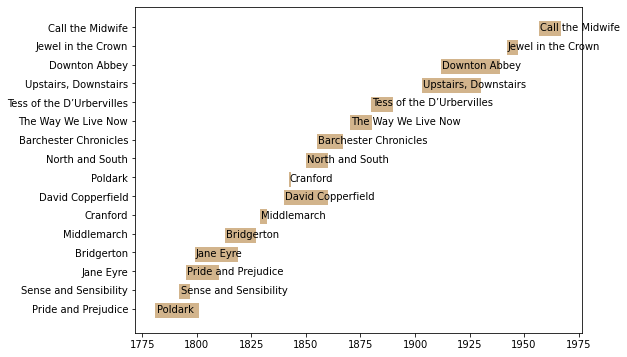

## Doctor Timeline

Following the template in the example above, we can construct our own broken horizontal bar graph to show the durations of each actor's tenure. We're going to try to get a working prototype before we consdier how to deal with David Tennant's particular situation.

### Graph 1

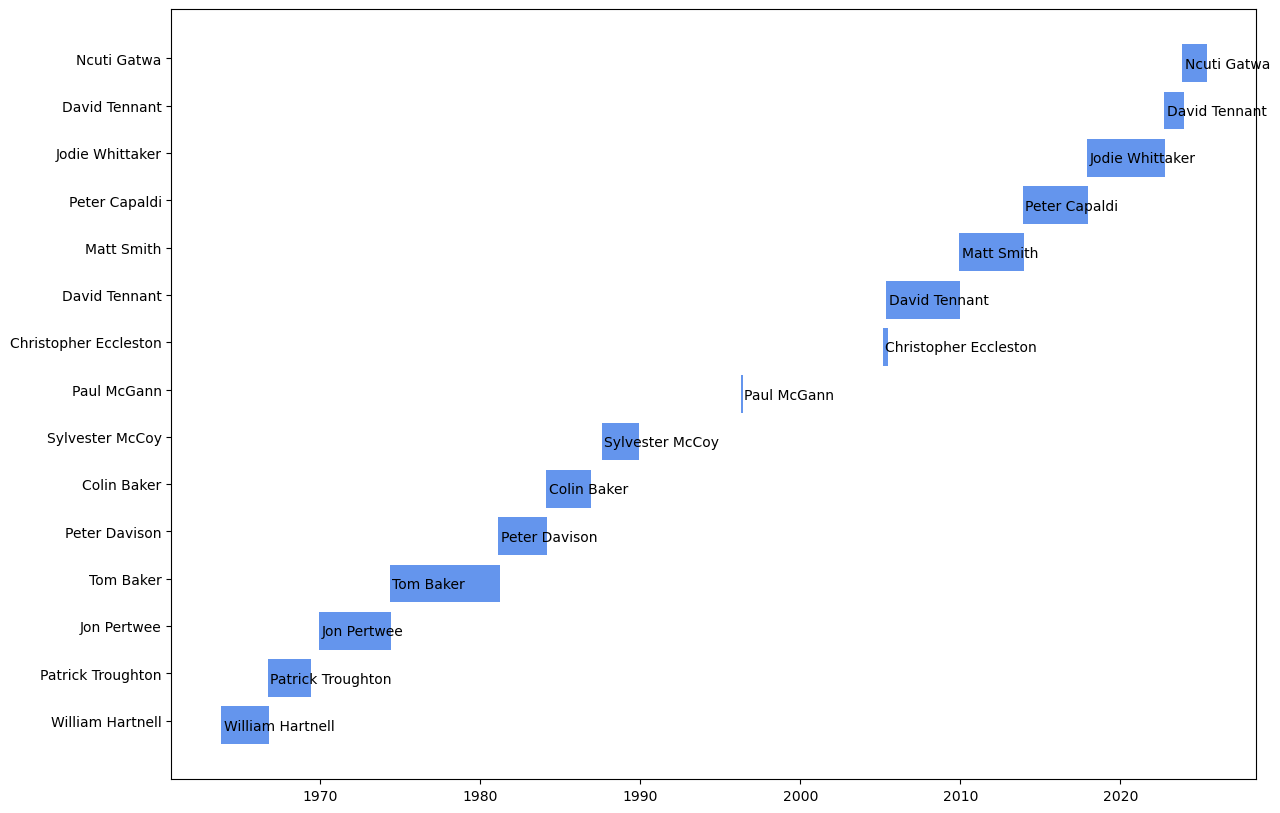

In [41]:
#"padding" will give some dimension to extremely short entries
#Paul McGann's stint as the Doctor has 0 length, so it would be invisible without padding
padding = datetime.timedelta(days=31)

#Create the figure and axes for the timeline:
fig, gnt = plt.subplots(figsize = (14, 10))

#Set labels for Y-Axis
y_tick_labels = doctor_tenures.sort_values(by='Start Date')['Doctor']
y_pos = np.arange(len(y_tick_labels))
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)

#Plot the actor's stints, sorting by their start dates
for index, row in doctor_tenures.sort_values(by='Start Date').reset_index().iterrows():
    start_date = row['Start Date']
    duration = row['timediff'][0]
    
    gnt.broken_barh([(start_date-padding, duration+padding)], 
                    (index-0.5,0.8), 
                    facecolors =('cornflowerblue'),
                   label=row['Doctor'])
    gnt.text(start_date+padding, index-0.2, row['Doctor'])

### Graph 2

There are two David Tennants... while in the Whoniverse, the Tenth and Fourteenth Doctors are separate regenerations of the same entity, the real David Tennant has gone through no such transformative process (at least, not that we know of). Let's tidy this up by aligning both his stints as The Doctor in the same row.

We can accomplish this by using list comprehensions for each actor's start dates and the durations of their tenures, and then adding features to the graph based on the contents of those freshly-generated lists.

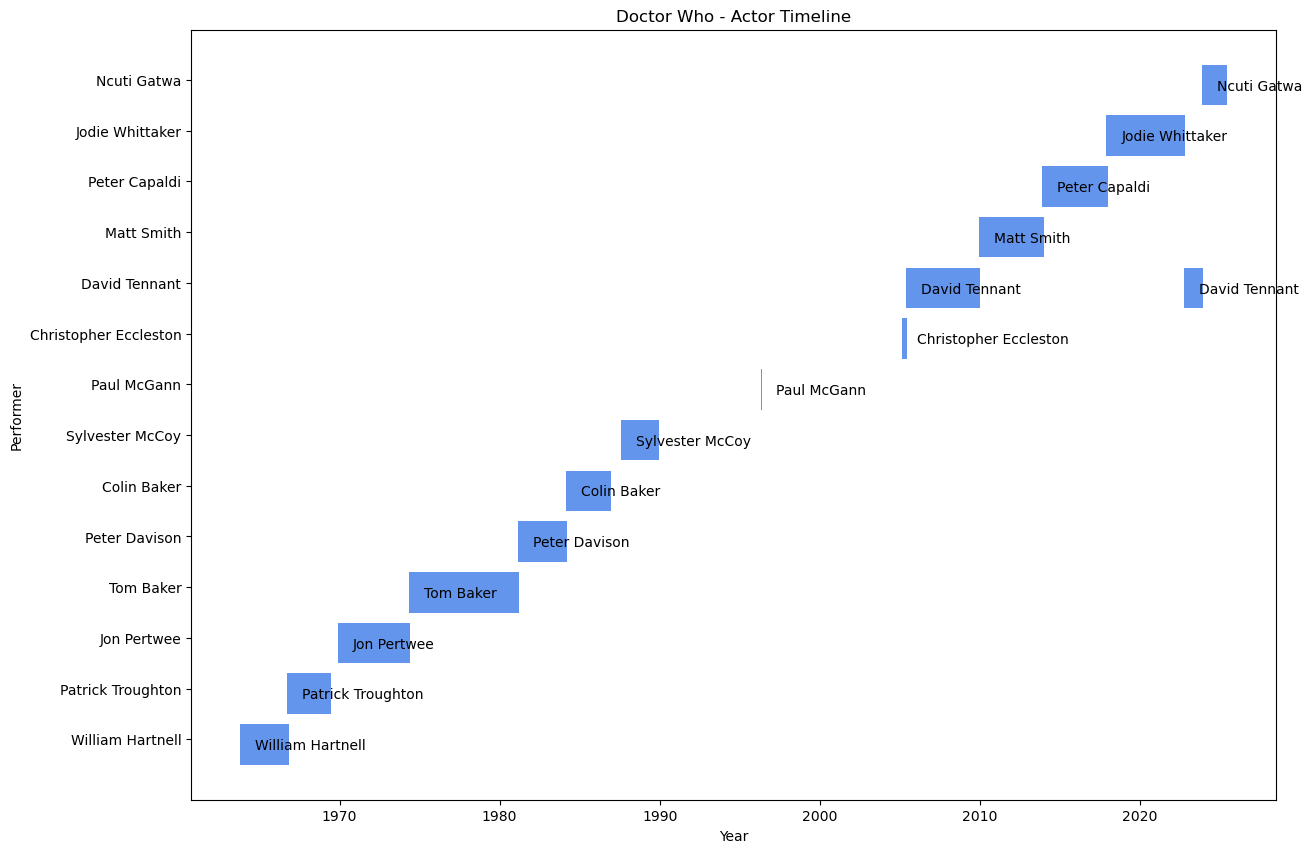

In [42]:
#"padding" will give some dimension to extremely short entries
#Paul McGann's stint as the Doctor has 0 length, so it would be invisible without padding
padding = datetime.timedelta(days=31)

#Create the figure and axes for the timeline:
fig, gnt = plt.subplots(figsize = (14, 10))

#Set labels for Y-Axis
y_tick_labels = doc_tenures_graph['Doctor']
y_pos = np.arange(len(y_tick_labels))
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)

#Plot the actor's stints, sorting by their INITIAL start dates
for index, row in doc_tenures_graph.iterrows():

    #Use list comprehensions to create sequence of start/end dates for each performer:
    start_dates = [x[0] for x in row['StartEnd']]
    durations = [y for y in row['timediff']]

    gnt.broken_barh([(start_date-padding, duration+padding) for start_date, duration in zip(start_dates, durations)], 
                    (index-0.5,0.8), 
                    facecolors =('cornflowerblue'),
                   label=row['Doctor'])
    gnt.text(start_dates[0]+padding*10, index-0.2, row['Doctor'])
    if len(start_dates) > 1:
        gnt.text(start_dates[1]+padding*10, index-0.2, row['Doctor'])

plt.title('Doctor Who - Actor Timeline')
plt.ylabel('Performer')
plt.xlabel('Year')

plt.show()

# End of Module 2